In [11]:
import tensorflow as tf
import numpy as np
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, LocallyConnected2D, Conv2D, MaxPooling2D, UpSampling2D, Conv3D, MaxPooling3D, UpSampling3D
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras import backend as K
import os.path
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import load_model
import h5py

In [12]:
def draw_images(images, shape = (28, 28), n=12):
    """
    params:
    > n: how many digits we will display
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(shape))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [13]:
x_train_mnist = np.load('x_train_mnist.npy')
x_train_small_mnist = np.load('x_train_small_mnist.npy')
x_train_upscaled_mnist = np.load('x_train_upscaled_mnist.npy')

x_train_cifar = np.load('x_train_cifar.npy')
x_train_small_cifar = np.load('x_train_small_cifar.npy')
x_train_upscaled_cifar = np.load('x_train_upscaled_cifar.npy')

x_test_mnist = np.load('x_test_mnist.npy')
x_test_small_mnist = np.load('x_test_small_mnist.npy')
x_test_upscaled_mnist = np.load('x_test_upscaled_mnist.npy')

x_test_cifar = np.load('x_test_cifar.npy')
x_test_small_cifar = np.load('x_test_small_cifar.npy')
x_test_upscaled_cifar = np.load('x_test_upscaled_cifar.npy')

Original training set Minst: 28 x 28


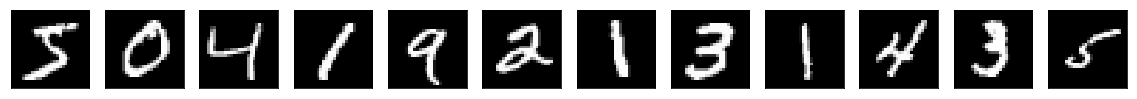

Smaller training set Minst: 14 x 14


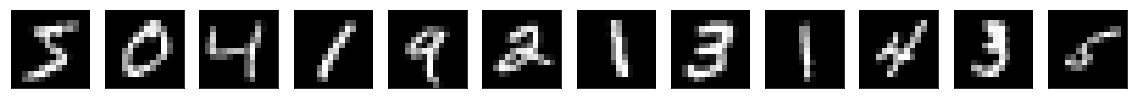

Autoupscaled training set Minst: 28 x 28


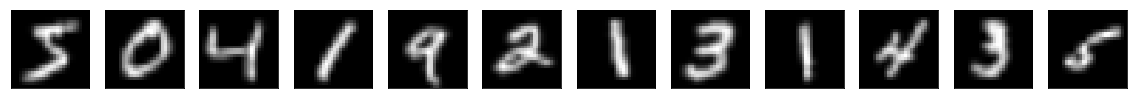

Original training set Cifar: 32 x 32


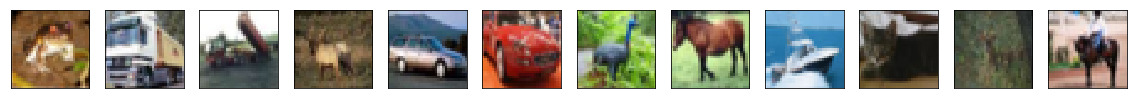

Smaller training set Cifar: 16 x 16


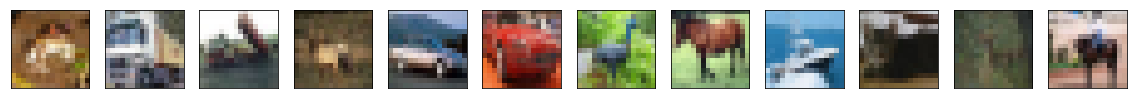

Autoupscaled training set Cifar: 32 x 32


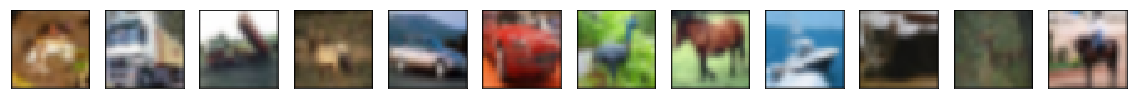

In [14]:
print("Original training set Minst: 28 x 28")
draw_images(x_train_mnist, shape=(28, 28))
print("Smaller training set Minst: 14 x 14")
draw_images(x_train_small_mnist, shape=(14, 14))
print("Autoupscaled training set Minst: 28 x 28")
draw_images(x_train_upscaled_mnist, shape=(28, 28))

print("Original training set Cifar: 32 x 32")
draw_images(x_train_cifar, shape=(32, 32, 3))
print("Smaller training set Cifar: 16 x 16")
draw_images(x_train_small_cifar, shape=(16, 16, 3))
print("Autoupscaled training set Cifar: 32 x 32")
draw_images(x_train_upscaled_cifar, shape=(32, 32, 3))

In [24]:
cnn_models = {"shallow_cnn_4lyr_3ch_cifar":
          lambda input_shape: 
          Sequential([
              Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
              MaxPooling2D(pool_size=2),
              UpSampling2D((2, 2)),
              Conv2D(3, (3, 3), activation='sigmoid', padding='same')
          ]),
          
          "shallow_cnn_8ch_mnist": 
          lambda input_shape: 
          Sequential([
              Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
              MaxPooling2D(pool_size=2),
              Conv2D(1, (3, 3), activation='relu', padding='same'),
              Conv2D(8, (3, 3), activation='relu', padding='same'), 
              UpSampling2D((2, 2)),
              Conv2D(1, (3, 3), activation='sigmoid', padding='same')
          ]),
    
          "shallow_cnn_8ch_cifar": 
          lambda input_shape: 
          Sequential([
              Conv2D(8*3, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
              MaxPooling2D(pool_size=2),
              Conv2D(3, (3, 3), activation='relu', padding='same'),
              Conv2D(8*3, (3, 3), activation='relu', padding='same'), 
              UpSampling2D((2, 2)),
              Conv2D(3, (3, 3), activation='sigmoid', padding='same')
          ]),
          
          "shallow_cnn_8ch_mnist": 
          lambda input_shape: 
          Sequential([
              Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
              MaxPooling2D(pool_size=2),
              Conv2D(1, (3, 3), activation='relu', padding='same'),
              Conv2D(8, (3, 3), activation='relu', padding='same'), 
              UpSampling2D((2, 2)),
              Conv2D(1, (3, 3), activation='sigmoid', padding='same')
          ]),
          
          "shallow_cnn_16ch_cifar": 
          lambda input_shape: 
          Sequential([
              Conv2D(16*3, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
              MaxPooling2D(pool_size=2),
              Conv2D(3, (3, 3), activation='relu', padding='same'),
              Conv2D(16*3, (3, 3), activation='relu', padding='same'), 
              UpSampling2D((2, 2)),
              Conv2D(3, (3, 3), activation='sigmoid', padding='same')
          ]),
          
          "shallow_cnn_16ch_mnist": 
          lambda input_shape: 
          Sequential([
              Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
              MaxPooling2D(pool_size=2),
              Conv2D(1, (3, 3), activation='relu', padding='same'),
              Conv2D(16, (3, 3), activation='relu', padding='same'), 
              UpSampling2D((2, 2)),
              Conv2D(1, (3, 3), activation='sigmoid', padding='same')
          ])
         }

In [25]:
from keras.callbacks import ModelCheckpoint


def model_train(x_train, y_train, x_test, y_test, epochs=5, batch_size=128, retrain=False, model_name="shallow_cnn_16ch_mnist", model_fn=None):
    model_filename = model_name + ".h5"
    
    if os.path.isfile(model_filename) and not retrain:
        model = load_model(model_filename)
        model.summary()
    else:
        input_image_dim= np.shape(x_train[0])
        model = model_fn(input_image_dim)
        
        adam = Adam(lr=0.0003)
        model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
        print(model.summary())
        
        checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
        callbacks_list = [checkpoint]
        print("Training")
        model.fit(x_train, y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle=True,
                     callbacks=callbacks_list,
                     validation_data=(x_test, y_test))
#         model.save(model_filename)
    return model

In [26]:
import time

for model_name, model_fn in cnn_models.items():
    print("Training: " + model_name)
    ts = time.time()
    if "mnist" in model_name:
        model = model_train(
            x_train = x_train_mnist,
            y_train = x_train_mnist,
            x_test = x_test_mnist,
            y_test = x_test_mnist,
            model_fn = model_fn,
            model_name = model_name,
            epochs=50,
            retrain=True
        )
    elif "cifar" in model_name:
        model = model_train(
            x_train = x_train_cifar,
            y_train = x_train_cifar,
            x_test = x_test_cifar,
            y_test = x_test_cifar,
            model_fn = model_fn,
            model_name = model_name,
            epochs=50,
            retrain=True
        )
    te = time.time()
    print("Time taken: {:.2f}".format(te-ts))

Training: shallow_cnn_4lyr_3ch_cifar
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 3)         84        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 3)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 3)         84        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________
Time taken: 1.20
Training: shallow_cnn_8ch_mnist
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 8)         80 